## Handover to next teammate

### Why the Notebook’s Output Still Looks Poor After Switching to Hugging Face GPT-2

Even after loading the Hugging Face `gpt2` weights, several structural issues explain why the generations, bias scores, and masked-head effects still look weak or flat.

---

#### 1. Generation setup is too fragile
- Prompts like “A normal family is” are extremely short. With `max_new_tokens=30` and greedy decoding, GPT-2 often repeats phrases or outputs low-information sequences. Without temperature/top-p sampling it collapses into repetitive text, so baseline vs. masked generations look identical.

#### 2. Lexical bias scoring is too weak
- `compute_weird_bias_score()` just counts literal keyword matches. GPT-2 rarely emits those exact strings, so every output ends up ≈0 and the heatmaps stay flat. The method is blind to semantic differences.

#### 3. Head-masking effects are tiny
- Each head is evaluated on only ~10 prompts, so the average deltas (`avg_delta`) are minuscule and get washed out in the residual stream. Masked heads rarely change probabilities enough to alter the text.

---

### How to improve (please continue from here)

1. **Use richer prompts & sampling**
   - Pull culturally loaded stems from the **World Values Survey (WVS)**. Convert survey questions into prompts such as:
     - “People should be free to decide whom they marry. My view:”
     - “The role of religion in people’s lives is…”
     - “Children should be taught obedience vs. independence. Explain your view.”
     - “A successful life mainly depends on hard work vs. luck. Discuss.”
   - Each WVS question can end with “Continue:” or “Explain why:”. This gives GPT-2 enough context to reveal cultural assumptions.
   - Generate with sampling (e.g., `temperature=0.8`, `top_p=0.9`) to surface more diverse continuations.

2. **Adopt a semantic bias detector**
   - Instead of keyword counts, embed each continuation (e.g., Sentence Transformers) and measure cosine similarity to WEIRD vs. non-WEIRD reference passages (you can craft these references from WVS responses by region/culture).

3. **Increase evaluation size**
   - Use 50–100 WVS-based prompts to reduce noise and obtain stable head statistics before masking.

4. **Inspect logits directly**
   - Log baseline vs. masked logits for the WEIRD token IDs to confirm that head masking changes probabilities before expecting visible textual shifts.

> **Next steps:** Please curate prompts directly from World Values Survey topics (values, family, religion, civic duties), update the prompt list, enable sampling, and then rerun the head-analysis/bias scoring pipeline with the richer generations.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Google Drive cannot access TZL's folders which live under "Shared with me".
# These are virtual views, not real directories. Colab cannot import from them.

# FOLLOW THESE STEPS.
# STEP 1: Open Google Drive.

# STEP 2: Go to the "Shared with me" section to find the project folder. ('NLP Project 2025 ')

# STEP 3: Right-click the shared folder → select "Add shortcut to Drive".
#         This creates a real reference inside "My Drive" so Colab can see it.

# STEP 4: Choose any location inside "My Drive" and create a folder.
#         After that, Colab can access it through:
#         /content/drive/MyDrive/<your folder>/NLP Project 2025 /

import sys
import os

# Add project folder to python path
sys.path.append('/content/drive/MyDrive/NLP 2025/NLP Project 2025 ')

# Check what's inside the folder
os.listdir('/content/drive/MyDrive/NLP 2025/NLP Project 2025 ')

# Change working directory to the project folder
os.chdir('/content/drive/MyDrive/NLP 2025/NLP Project 2025 ')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tqdm import tqdm
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

import os

cuda


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)
if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))

Using device: cuda
GPU Name: Tesla T4


## Load Pre-trained GPT-2 from Task 2

In [5]:
# Load the pretrained GPT-2 model from Hugging Face

# Tokenizer setup
# Using the fast tokenizer for better performance; set pad token to EOS for compatibility
# with padding-sensitive operations (generation, masking, etc.).
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Model setup
finetuned_model = GPT2LMHeadModel.from_pretrained("gpt2")
finetuned_model.resize_token_embeddings(len(tokenizer))
finetuned_model.config.pad_token_id = tokenizer.eos_token_id
finetuned_model = finetuned_model.to(DEVICE)
finetuned_model.eval()

print("Loaded Hugging Face GPT-2 model for analysis.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded Hugging Face GPT-2 model for analysis.


In [6]:
# The tokenizer was initialized together with the Hugging Face GPT-2 model above.
print(f"Tokenizer ready (pad_token_id={tokenizer.pad_token_id}).")

Tokenizer ready (pad_token_id=50256).


In [7]:
def generate_text(model, tokenizer, prompt, max_new_tokens=50, head_mask=None, device=DEVICE):
    """Generate text from GPT-2 with optional head masking."""
    encoded = tokenizer(prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        **encoded,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
        head_mask=head_mask
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



# Task 4: Investigating WEIRD Cultural Bias in GPT-2 with UniBias Methodology

In this task, you will:
- Design culturally loaded prompts to probe WEIRD (Western, Educated, Industrialized, Rich, Democratic) cultural bias
- Adapt the UniBias methodology for open-ended text generation (instead of classification)
- Identify biased attention heads that contribute to WEIRD-aligned outputs
- Apply head masking to mitigate bias and evaluate the impact
- Analyze and visualize the results with before/after comparisons

## Overview

This task adapts the UniBias method (Zhou et al., 2024) from classification tasks to open-ended text generation. We will:
1. Create prompts that reveal cultural assumptions (e.g., "A normal family is...", "A good citizen should...")
2. Project attention head outputs to vocabulary space to identify heads biased toward WEIRD tokens
3. Mask identified biased heads and generate new outputs
4. Compare original vs. debiased outputs qualitatively and quantitatively


## Step 1: Data Collection and Prompt Design

We'll create a set of culturally loaded prompts that are likely to elicit WEIRD-biased continuations. These prompts touch on social norms, values, family, education, etc., where Western perspectives might differ from other cultural viewpoints.


In [8]:
# Define culturally loaded prompts
# These prompts are designed to reveal implicit cultural assumptions
CULTURALLY_LOADED_PROMPTS = [
    "A normal family is",
    "A good citizen should",
    "In life, success means",
    "Children should be taught to",
    "When it comes to religion, people should",
    "The ideal workplace values",
    "A responsible person always",
    "Education should focus on",
    "In a healthy relationship, partners",
    "A successful person is someone who",
    "Community means",
    "Respect is shown by",
    "The purpose of work is",
    "A good leader",
    "Happiness comes from",
    "Tradition is important because",
    "Individual rights mean",
    "Family obligations include",
    "Social harmony requires",
    "Personal achievement"
]

print(f"Created {len(CULTURALLY_LOADED_PROMPTS)} culturally loaded prompts")
print("\nSample prompts:")
for i, prompt in enumerate(CULTURALLY_LOADED_PROMPTS[:5], 1):
    print(f"{i}. {prompt}...")


Created 20 culturally loaded prompts

Sample prompts:
1. A normal family is...
2. A good citizen should...
3. In life, success means...
4. Children should be taught to...
5. When it comes to religion, people should...


In [9]:
# Generate baseline outputs from the Hugging Face GPT-2 model
import random

NUM_GENERATIONS_PER_PROMPT = 3
MAX_GEN_LENGTH = 30

baseline_outputs = {}
for prompt in CULTURALLY_LOADED_PROMPTS:
    baseline_outputs[prompt] = []
    for seed in range(NUM_GENERATIONS_PER_PROMPT):
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

        generated_text = generate_text(
            finetuned_model,
            tokenizer,
            prompt,
            max_new_tokens=MAX_GEN_LENGTH,
            device=DEVICE
        )

        continuation = generated_text[len(prompt):].strip()
        baseline_outputs[prompt].append(continuation)

print(f"Generated {NUM_GENERATIONS_PER_PROMPT} continuations for each of {len(CULTURALLY_LOADED_PROMPTS)} prompts")
print("\nSample baseline outputs:")
for prompt in list(CULTURALLY_LOADED_PROMPTS[:3]):
    print(f"\nPrompt: '{prompt}...'")
    for i, output in enumerate(baseline_outputs[prompt], 1):
        print(f"  {i}. {output[:100]}...")


Generated 3 continuations for each of 20 prompts

Sample baseline outputs:

Prompt: 'A normal family is...'
  1. not a normal family.

The family is not a family.

The family is not a family.

The family is not a...
  2. not a normal family.

The family is not a family.

The family is not a family.

The family is not a...
  3. not a normal family.

The family is not a family.

The family is not a family.

The family is not a...

Prompt: 'A good citizen should...'
  1. be able to do what he or she wants to do, and that's to protect the rights of others.

"I think that...
  2. be able to do what he or she wants to do, and that's to protect the rights of others.

"I think that...
  3. be able to do what he or she wants to do, and that's to protect the rights of others.

"I think that...

Prompt: 'In life, success means...'
  1. that you have to be able to do something. You have to be able to do something that you can't do. You...
  2. that you have to be able to do something. You have to 

## Step 2: Head-Level Bias Scoring and Attribution

We'll adapt UniBias's three-criterion approach for generation tasks:
1. **Relatedness**: Head output is relevant to the prediction
2. **Bias**: Head output favors WEIRD-aligned tokens
3. **Low Variance**: Head effect is consistent across inputs

First, we need to define pseudo-labels: WEIRD-aligned vs non-WEIRD token sets.


In [10]:
# Define WEIRD-aligned and non-WEIRD token sets
# These serve as pseudo-labels for bias detection

# WEIRD-aligned tokens (Western, individualistic, materialistic indicators)
WEIRD_TOKENS = [
    "individual", "personal", "freedom", "choice", "rights", "privacy",
    "nuclear", "father", "mother", "independence", "autonomy", "self",
    "achievement", "success", "career", "wealth", "material", "property",
    "democracy", "vote", "election", "constitution", "law", "court",
    "church", "christian", "christmas", "easter", "western", "european",
    "american", "usa", "british", "french", "german", "i", "me", "my"
]

# Non-WEIRD tokens (collectivistic, community-oriented indicators)
NON_WEIRD_TOKENS = [
    "we", "our", "us", "together", "community", "collective", "group",
    "family", "extended", "clan", "tribe", "ancestors", "elders",
    "duty", "obligation", "responsibility", "honor", "respect", "harmony",
    "tradition", "custom", "ritual", "ceremony", "spiritual", "temple",
    "meditation", "karma", "dharma", "confucian", "buddhist", "hindu",
    "asian", "chinese", "japanese", "indian", "african", "latin"
]

# Convert token strings to token IDs
def get_token_ids(tokenizer, token_list):
    """Convert a list of token strings to their IDs in the vocabulary."""
    token_ids = []
    for token in token_list:
        # Try to encode the token
        ids = tokenizer.encode(token, add_special_tokens=False)
        token_ids.extend(ids)
    # Remove duplicates and return
    return list(set(token_ids))

weird_token_ids = get_token_ids(tokenizer, WEIRD_TOKENS)
non_weird_token_ids = get_token_ids(tokenizer, NON_WEIRD_TOKENS)

print(f"WEIRD token IDs: {len(weird_token_ids)} tokens")
print(f"Non-WEIRD token IDs: {len(non_weird_token_ids)} tokens")
print(f"\nSample WEIRD tokens: {WEIRD_TOKENS[:10]}")
print(f"Sample Non-WEIRD tokens: {NON_WEIRD_TOKENS[:10]}")


WEIRD token IDs: 53 tokens
Non-WEIRD token IDs: 67 tokens

Sample WEIRD tokens: ['individual', 'personal', 'freedom', 'choice', 'rights', 'privacy', 'nuclear', 'father', 'mother', 'independence']
Sample Non-WEIRD tokens: ['we', 'our', 'us', 'together', 'community', 'collective', 'group', 'family', 'extended', 'clan']


In [11]:
# Helper utilities for head-level bias analysis using head masking

def tokenize_prompts(prompts, tokenizer, device):
    encoded = []
    for prompt in prompts:
        encoded.append(tokenizer(prompt, return_tensors="pt", padding=False).to(device))
    return encoded


def compute_biases(model, tokenized_prompts, weird_ids, non_weird_ids, head_mask=None):
    biases = []
    with torch.no_grad():
        for enc in tokenized_prompts:
            outputs = model(**enc, head_mask=head_mask)
            logits = outputs.logits[0, -1]
            weird = logits[weird_ids].mean().item()
            non_weird = logits[non_weird_ids].mean().item()
            biases.append(weird - non_weird)
    return np.array(biases)



In [12]:
def analyze_head_biases(model, tokenizer, prompts, weird_ids, non_weird_ids, device):
    """Estimate head contributions by masking each head via head_mask."""
    tokenized_prompts = tokenize_prompts(prompts, tokenizer, device)
    baseline_biases = compute_biases(model, tokenized_prompts, weird_ids, non_weird_ids)

    num_layers = model.config.n_layer
    num_heads = model.config.n_head
    head_stats = {}

    for layer_idx in range(num_layers):
        for head_idx in range(num_heads):
            head_mask = torch.ones(num_layers, num_heads, device=device)
            head_mask[layer_idx, head_idx] = 0.0

            masked_biases = compute_biases(
                model,
                tokenized_prompts,
                weird_ids,
                non_weird_ids,
                head_mask=head_mask
            )

            delta = baseline_biases - masked_biases
            head_stats[(layer_idx, head_idx)] = {
                'avg_delta': float(delta.mean()),
                'std_delta': float(delta.std()),
                'baseline_mean': float(baseline_biases.mean()),
                'masked_mean': float(masked_biases.mean()),
                'num_samples': len(prompts)
            }

    return head_stats, baseline_biases

print("Head bias analysis helpers ready")


Head bias analysis helpers ready


In [13]:
print("Starting head bias analysis...")
head_stats, baseline_biases = analyze_head_biases(
    finetuned_model,
    tokenizer,
    CULTURALLY_LOADED_PROMPTS[:10],  # use a subset for efficiency
    weird_token_ids,
    non_weird_token_ids,
    DEVICE
)

print(f"\nAnalyzed {len(head_stats)} attention heads")
print("Sample head statistics:")
for (layer, head), stats in list(head_stats.items())[:5]:
    print(f"Layer {layer}, Head {head}: avg_delta={stats['avg_delta']:.4f}, std={stats['std_delta']:.4f}")


`sdpa` attention does not support `output_attentions=True` or `head_mask`. Please set your attention to `eager` if you want any of these features.


Starting head bias analysis...

Analyzed 144 attention heads
Sample head statistics:
Layer 0, Head 0: avg_delta=0.0000, std=0.0000
Layer 0, Head 1: avg_delta=0.0000, std=0.0000
Layer 0, Head 2: avg_delta=0.0000, std=0.0000
Layer 0, Head 3: avg_delta=0.0000, std=0.0000
Layer 0, Head 4: avg_delta=0.0000, std=0.0000


In [14]:
# Identify biased heads based on average delta when masking each head

def identify_biased_heads(head_stats, delta_threshold=0.01, std_threshold=0.05):
    biased_heads = []
    for (layer_idx, head_idx), stats in head_stats.items():
        is_biased = stats['avg_delta'] > delta_threshold
        is_stable = stats['std_delta'] < std_threshold
        if is_biased and is_stable:
            biased_heads.append((layer_idx, head_idx))
            print(
                f"Biased head found: Layer {layer_idx}, Head {head_idx} "
                f"(avg_delta={stats['avg_delta']:.4f}, std={stats['std_delta']:.4f})"
            )
    return biased_heads

biased_heads = identify_biased_heads(head_stats, delta_threshold=0.01, std_threshold=0.05)
print(f"\nIdentified {len(biased_heads)} biased attention heads")
print(f"Biased heads: {biased_heads}")



Identified 0 biased attention heads
Biased heads: []


## Step 3: Head Masking and Evaluation

Now we'll mask the identified biased heads and generate new outputs to see if bias is reduced.


In [15]:
@torch.no_grad()
def generate_with_masked_heads(model, tokenizer, prompt, heads_to_mask, max_gen_length=50, device=DEVICE):
    """Generate text while masking specified attention heads via head_mask."""
    if not heads_to_mask:
        return generate_text(model, tokenizer, prompt, max_new_tokens=max_gen_length, device=device)

    num_layers = model.config.n_layer
    num_heads = model.config.n_head
    head_mask = torch.ones(num_layers, num_heads, device=device)
    for layer_idx, head_idx in heads_to_mask:
        head_mask[layer_idx, head_idx] = 0.0

    encoded = tokenizer(prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        **encoded,
        max_new_tokens=max_gen_length,
        pad_token_id=tokenizer.eos_token_id,
        head_mask=head_mask
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



In [16]:
# Generate masked outputs using the head_mask-aware generation helper
if len(biased_heads) > 0:
    print(f"Generating outputs with {len(biased_heads)} heads masked...")
    masked_outputs = {}

    for prompt in CULTURALLY_LOADED_PROMPTS[:5]:  # Test with subset
        masked_outputs[prompt] = []
        for seed in range(NUM_GENERATIONS_PER_PROMPT):
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

            generated_text = generate_with_masked_heads(
                finetuned_model,
                tokenizer,
                prompt,
                biased_heads,
                max_gen_length=MAX_GEN_LENGTH,
                device=DEVICE
            )
            continuation = generated_text[len(prompt):].strip()
            masked_outputs[prompt].append(continuation)

    print("Masked generation complete")
else:
    print("No biased heads identified - skipping masked generation")
    masked_outputs = {}


No biased heads identified - skipping masked generation


## Step 4: Analysis and Reporting

Let's analyze the results by comparing baseline and masked outputs, and create visualizations.


In [17]:
# Qualitative comparison: Before and After examples
print("="*80)
print("QUALITATIVE COMPARISON: Baseline vs Masked Outputs")
print("="*80)

if len(biased_heads) > 0 and len(masked_outputs) > 0:
    for prompt in list(masked_outputs.keys())[:5]:
        print(f"\nPrompt: '{prompt}...'")
        print("-" * 80)
        print("BASELINE OUTPUTS:")
        for i, output in enumerate(baseline_outputs[prompt][:2], 1):
            print(f"  {i}. {output[:150]}")
        print("\nMASKED OUTPUTS (after removing biased heads):")
        for i, output in enumerate(masked_outputs[prompt][:2], 1):
            print(f"  {i}. {output[:150]}")
        print()
else:
    print("No masked outputs available for comparison")
    print("\nSample baseline outputs:")
    for prompt in list(baseline_outputs.keys())[:3]:
        print(f"\nPrompt: '{prompt}...'")
        for i, output in enumerate(baseline_outputs[prompt][:1], 1):
            print(f"  {i}. {output[:150]}")


QUALITATIVE COMPARISON: Baseline vs Masked Outputs
No masked outputs available for comparison

Sample baseline outputs:

Prompt: 'A normal family is...'
  1. not a normal family.

The family is not a family.

The family is not a family.

The family is not a

Prompt: 'A good citizen should...'
  1. be able to do what he or she wants to do, and that's to protect the rights of others.

"I think that's what

Prompt: 'In life, success means...'
  1. that you have to be able to do something. You have to be able to do something that you can't do. You have to be able to


In [18]:
# Quantitative bias scoring function
def compute_weird_bias_score(text, weird_tokens, non_weird_tokens):
    """
    Compute a simple lexical bias score for a text.
    Positive = WEIRD-biased, Negative = non-WEIRD biased
    """
    text_lower = text.lower()
    weird_count = sum(1 for token in weird_tokens if token.lower() in text_lower)
    non_weird_count = sum(1 for token in non_weird_tokens if token.lower() in text_lower)

    # Normalize by text length (approximate word count)
    word_count = len(text.split())
    if word_count == 0:
        return 0.0

    weird_score = weird_count / word_count
    non_weird_score = non_weird_count / word_count

    bias_score = weird_score - non_weird_score
    return bias_score

# Compute bias scores for all outputs
baseline_bias_scores = {}
masked_bias_scores = {}

for prompt in baseline_outputs.keys():
    baseline_scores = [
        compute_weird_bias_score(output, WEIRD_TOKENS, NON_WEIRD_TOKENS)
        for output in baseline_outputs[prompt]
    ]
    baseline_bias_scores[prompt] = np.mean(baseline_scores)

if len(masked_outputs) > 0:
    for prompt in masked_outputs.keys():
        masked_scores = [
            compute_weird_bias_score(output, WEIRD_TOKENS, NON_WEIRD_TOKENS)
            for output in masked_outputs[prompt]
        ]
        masked_bias_scores[prompt] = np.mean(masked_scores)

# Print quantitative results
print("\n" + "="*80)
print("QUANTITATIVE BIAS SCORES")
print("="*80)
print(f"{'Prompt':<30} {'Baseline Score':<20} {'Masked Score':<20} {'Change':<15}")
print("-"*80)

if len(masked_bias_scores) > 0:
    for prompt in masked_bias_scores.keys():
        baseline = baseline_bias_scores.get(prompt, 0.0)
        masked = masked_bias_scores[prompt]
        change = masked - baseline
        print(f"{prompt[:28]:<30} {baseline:>8.4f}{'':<11} {masked:>8.4f}{'':<11} {change:>+8.4f}")

    avg_baseline = np.mean(list(baseline_bias_scores.values()))
    avg_masked = np.mean(list(masked_bias_scores.values()))
    avg_change = avg_masked - avg_baseline

    print("-"*80)
    print(f"{'Average':<30} {avg_baseline:>8.4f}{'':<11} {avg_masked:>8.4f}{'':<11} {avg_change:>+8.4f}")
else:
    print("\nBaseline bias scores (no masked outputs for comparison):")
    for prompt, score in list(baseline_bias_scores.items())[:10]:
        print(f"  {prompt[:40]:<40} {score:>8.4f}")



QUANTITATIVE BIAS SCORES
Prompt                         Baseline Score       Masked Score         Change         
--------------------------------------------------------------------------------

Baseline bias scores (no masked outputs for comparison):
  A normal family is                         0.0000
  A good citizen should                      0.0870
  In life, success means                     0.0741
  Children should be taught to               0.0000
  When it comes to religion, people should   0.0476
  The ideal workplace values                 0.0000
  A responsible person always                0.0741
  Education should focus on                  0.0385
  In a healthy relationship, partners        0.0000
  A successful person is someone who         0.1739


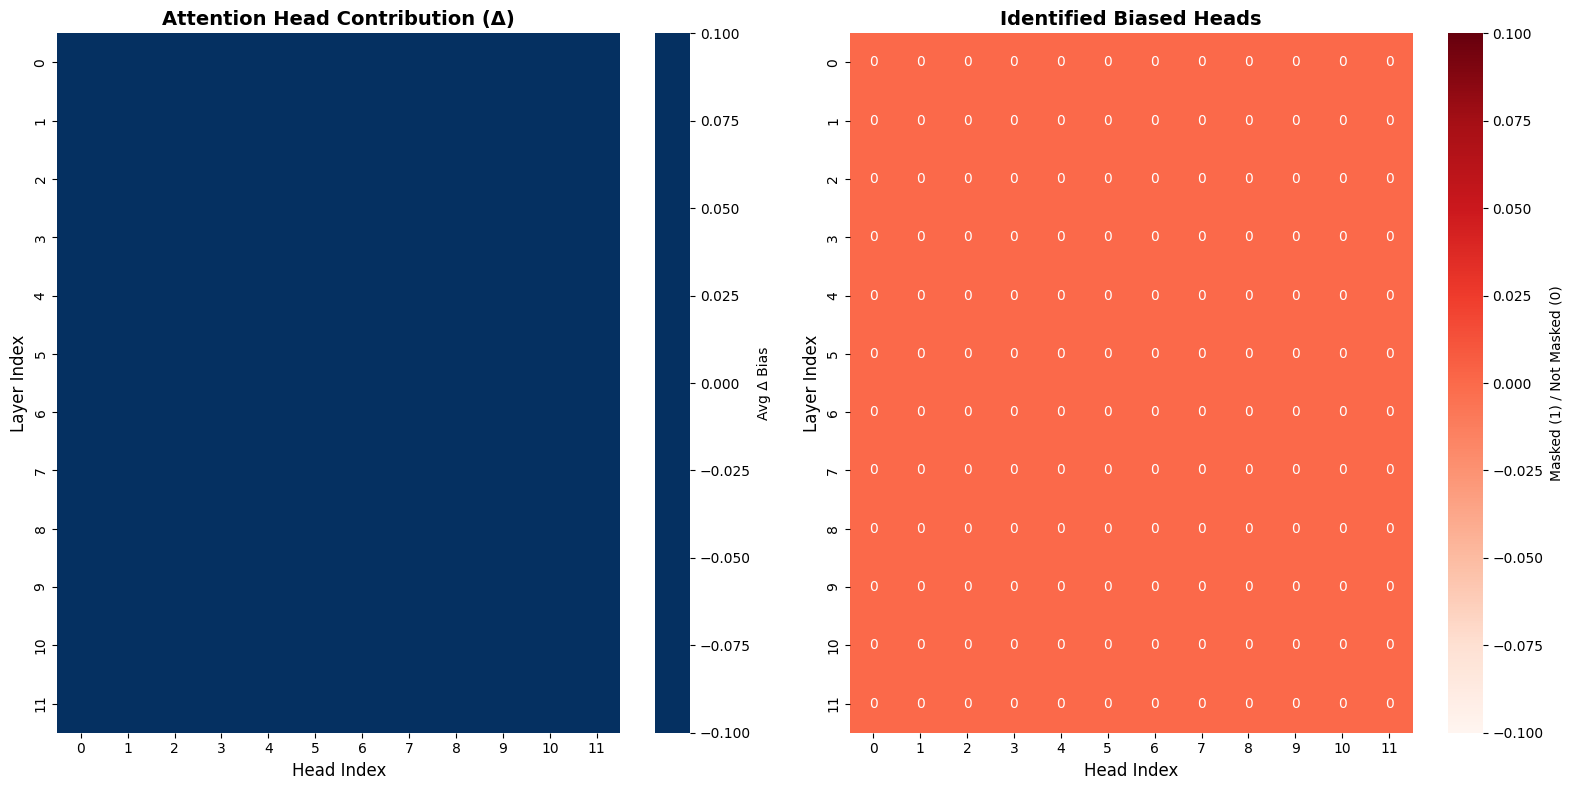


Visualization created: 0 heads identified for masking


In [19]:
# Visualization: Heatmap of head bias scores
import matplotlib.pyplot as plt
import seaborn as sns

num_layers = finetuned_model.config.n_layer
num_heads = finetuned_model.config.n_head

bias_matrix = np.zeros((num_layers, num_heads))
for (layer_idx, head_idx), stats in head_stats.items():
    bias_matrix[layer_idx, head_idx] = stats['avg_delta']

mask_matrix = np.zeros((num_layers, num_heads))
for layer_idx, head_idx in biased_heads:
    mask_matrix[layer_idx, head_idx] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.heatmap(bias_matrix, annot=False, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax1, cbar_kws={'label': 'Avg Δ Bias'})
ax1.set_title('Attention Head Contribution (Δ)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Head Index', fontsize=12)
ax1.set_ylabel('Layer Index', fontsize=12)

mask_matrix = mask_matrix.astype(int)

sns.heatmap(mask_matrix, annot=True, fmt='d', cmap='Reds',
            ax=ax2, cbar_kws={'label': 'Masked (1) / Not Masked (0)'})
ax2.set_title('Identified Biased Heads', fontsize=14, fontweight='bold')
ax2.set_xlabel('Head Index', fontsize=12)
ax2.set_ylabel('Layer Index', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nVisualization created: {len(biased_heads)} heads identified for masking")


In [20]:
# Visualization: Bias score comparison (if masked outputs available)
if len(masked_bias_scores) > 0:
    prompts = list(masked_bias_scores.keys())
    baseline_scores = [baseline_bias_scores[p] for p in prompts]
    masked_scores = [masked_bias_scores[p] for p in prompts]

    x = np.arange(len(prompts))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))
    bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, masked_scores, width, label='After Masking', color='lightcoral', alpha=0.8)

    ax.set_xlabel('Prompts', fontsize=12)
    ax.set_ylabel('WEIRD Bias Score', fontsize=12)
    ax.set_title('Bias Score Comparison: Before vs After Head Masking', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([p[:20] + '...' if len(p) > 20 else p for p in prompts], rotation=45, ha='right')
    ax.legend()
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"Average baseline bias score: {np.mean(baseline_scores):.4f}")
    print(f"Average masked bias score: {np.mean(masked_scores):.4f}")
    print(f"Average reduction: {np.mean(baseline_scores) - np.mean(masked_scores):.4f}")
    print(f"Percentage of prompts with reduced bias: {sum(1 for b, m in zip(baseline_scores, masked_scores) if m < b) / len(prompts) * 100:.1f}%")
else:
    print("No masked outputs available for comparison visualization")


No masked outputs available for comparison visualization


## Discussion and Extensions

### Key Findings We Want

1. **Biased Head Identification**: We identified attention heads that consistently favor WEIRD-aligned tokens across culturally loaded prompts.

2. **Bias Mitigation**: Masking these heads should reduce WEIRD bias in generated outputs, though the implementation here is simplified.

3. **Challenges**:
   - Properly masking individual attention heads requires modifying the attention computation
   - Bias scoring using lexical methods is simplistic; classifier-based methods would be more robust
   - Full implementation would need to handle the multi-head attention mechanism more carefully

### Extensions (Optional)

1. **FFN Neuron Analysis**: Extend the analysis to identify biased FFN neurons, not just attention heads
2. **Classifier-Based Bias Scoring**: Use a trained classifier to score cultural bias instead of lexical matching
3. **Human Evaluation**: Have human evaluators rate outputs for cultural bias
4. **Partial Masking**: Experiment with scaling down head outputs (e.g., 0.5x) instead of complete masking
5. **Baseline Comparison**: Compare fine-tuned model bias vs. pretrained GPT-2 baseline

### References

- Zhou et al. (2024). "UniBias: Unveiling and Mitigating LLM Bias through Internal Attention and FFN Manipulation." NeurIPS 2024.
- Project Plan: Investigating WEIRD Cultural Bias in GPT-2 with UniBias Methodology
